In [97]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


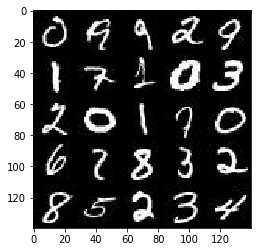

In [26]:
#minist
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images,'L'), cmap='gray')

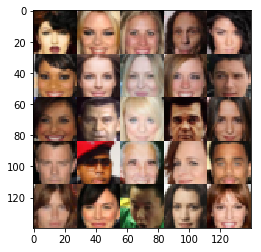

In [98]:
#CelebA
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [28]:

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


In [1]:

def model_inputs(image_width, image_height, image_channels, z_dim):

    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_images, z_data, learning_rate


In [2]:
def discriminator(images, reuse=False):

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


In [3]:
def generator(z, out_channel_dim, is_train=True):

    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha*h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha*h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha*h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 1, 1, 'same')
        out = tf.tanh(logits)
    return out


In [4]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return g_loss, d_loss


In [5]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    tvars = tf.trainable_variables()
    gvars = [var for var in tvars if var.name.startswith('generator')]
    dvars = [var for var in tvars if var.name.startswith('discriminator')]
    
    g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1= beta1).minimize(g_loss, var_list=gvars)
    d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1= beta1).minimize(d_loss, var_list=dvars)

    return g_opt, d_opt


In [84]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):

    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [87]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape,
          data_image_mode):

    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    g_loss, d_loss = model_loss(real_input, z_input, img_channels)
    
    g_opt, d_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                z_sample = np.random.uniform(-1, 1, [batch_size, z_dim])
                steps += 1
                batch_images *= 2.0
                _ = sess.run(d_opt, feed_dict={real_input: batch_images,
                                               lr: learning_rate,
                                               z_input: z_sample,
                                               })
                _ = sess.run(g_opt, feed_dict={z_input: z_sample,
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % show_every== 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
        
                

Epoch 1/2... Discriminator Loss: 0.3497... Generator Loss: 2.4727 Sum Loss: 2.8223
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 3.6980 Sum Loss: 4.3968
Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 1.7935 Sum Loss: 2.6847
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.4560 Sum Loss: 1.8043
Epoch 1/2... Discriminator Loss: 2.6684... Generator Loss: 4.4962 Sum Loss: 7.1647
Epoch 1/2... Discriminator Loss: 3.5207... Generator Loss: 0.0570 Sum Loss: 3.5777
Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 1.5820 Sum Loss: 3.1449
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 1.1519 Sum Loss: 1.8710
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 2.3344 Sum Loss: 3.4379
Epoch 1/2... Discriminator Loss: 0.7140... Generator Loss: 3.9697 Sum Loss: 4.6837


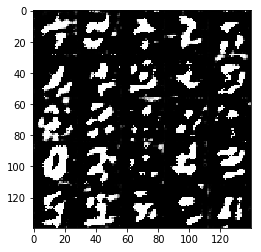

Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 4.3713 Sum Loss: 5.6310
Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.3149 Sum Loss: 1.8905
Epoch 1/2... Discriminator Loss: 0.8809... Generator Loss: 1.0477 Sum Loss: 1.9286
Epoch 1/2... Discriminator Loss: 0.7246... Generator Loss: 1.1474 Sum Loss: 1.8720
Epoch 1/2... Discriminator Loss: 0.6406... Generator Loss: 1.3363 Sum Loss: 1.9769
Epoch 1/2... Discriminator Loss: 2.1251... Generator Loss: 0.1839 Sum Loss: 2.3089
Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 0.8374 Sum Loss: 1.6246
Epoch 1/2... Discriminator Loss: 0.4481... Generator Loss: 1.6577 Sum Loss: 2.1059
Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 1.2180 Sum Loss: 2.2077
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 1.7566 Sum Loss: 2.7017


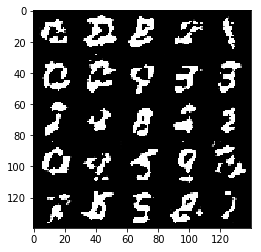

Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 2.4576 Sum Loss: 3.7968
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 1.9744 Sum Loss: 3.1642
Epoch 1/2... Discriminator Loss: 1.2083... Generator Loss: 0.9888 Sum Loss: 2.1971
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 2.4534 Sum Loss: 3.5228
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 0.9414 Sum Loss: 1.8601
Epoch 1/2... Discriminator Loss: 2.1010... Generator Loss: 0.2042 Sum Loss: 2.3052
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 1.5846 Sum Loss: 2.8385
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 1.4879 Sum Loss: 2.2480
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 2.6504 Sum Loss: 4.1848
Epoch 1/2... Discriminator Loss: 1.8473... Generator Loss: 0.2397 Sum Loss: 2.0870


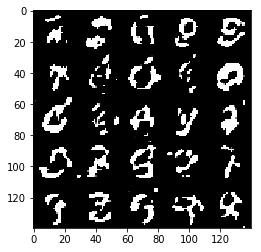

Epoch 1/2... Discriminator Loss: 1.9532... Generator Loss: 0.2087 Sum Loss: 2.1619
Epoch 1/2... Discriminator Loss: 0.8234... Generator Loss: 0.8837 Sum Loss: 1.7071
Epoch 1/2... Discriminator Loss: 0.7106... Generator Loss: 1.4973 Sum Loss: 2.2079
Epoch 1/2... Discriminator Loss: 0.6838... Generator Loss: 1.0711 Sum Loss: 1.7548
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 2.1743 Sum Loss: 3.2149
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.6648 Sum Loss: 1.7965
Epoch 1/2... Discriminator Loss: 0.6947... Generator Loss: 1.5221 Sum Loss: 2.2168
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 1.3546 Sum Loss: 2.2533
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.7887 Sum Loss: 1.8775
Epoch 1/2... Discriminator Loss: 2.4552... Generator Loss: 0.1624 Sum Loss: 2.6177


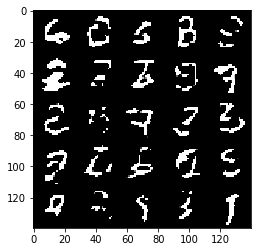

Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.5292 Sum Loss: 1.7020
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 1.1210 Sum Loss: 2.3180
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 2.2966 Sum Loss: 3.3411
Epoch 1/2... Discriminator Loss: 1.7630... Generator Loss: 0.3142 Sum Loss: 2.0772
Epoch 1/2... Discriminator Loss: 2.0629... Generator Loss: 0.2105 Sum Loss: 2.2733
Epoch 1/2... Discriminator Loss: 2.0159... Generator Loss: 0.2193 Sum Loss: 2.2352
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 0.9233 Sum Loss: 1.9071
Epoch 1/2... Discriminator Loss: 1.4906... Generator Loss: 0.4117 Sum Loss: 1.9023
Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.0531 Sum Loss: 1.7562
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 1.5127 Sum Loss: 2.4707


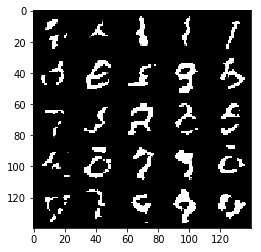

Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.5725 Sum Loss: 1.7921
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 0.7374 Sum Loss: 1.8038
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 1.0829 Sum Loss: 1.9975
Epoch 1/2... Discriminator Loss: 1.4759... Generator Loss: 0.3685 Sum Loss: 1.8444
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 2.9634 Sum Loss: 3.9267
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.4984 Sum Loss: 1.7675
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 2.5029 Sum Loss: 3.4363
Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 1.6356 Sum Loss: 2.3299
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.6579 Sum Loss: 2.3762
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 1.5678 Sum Loss: 2.2457


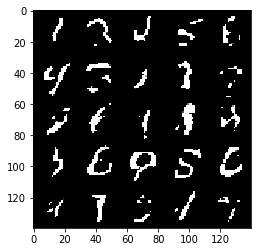

Epoch 1/2... Discriminator Loss: 0.8195... Generator Loss: 2.4460 Sum Loss: 3.2655
Epoch 1/2... Discriminator Loss: 0.5298... Generator Loss: 1.4645 Sum Loss: 1.9943
Epoch 1/2... Discriminator Loss: 0.9194... Generator Loss: 2.0571 Sum Loss: 2.9766
Epoch 1/2... Discriminator Loss: 0.6344... Generator Loss: 2.0775 Sum Loss: 2.7119
Epoch 1/2... Discriminator Loss: 1.5333... Generator Loss: 0.4457 Sum Loss: 1.9789
Epoch 1/2... Discriminator Loss: 0.8024... Generator Loss: 1.6610 Sum Loss: 2.4634
Epoch 1/2... Discriminator Loss: 1.9474... Generator Loss: 4.3142 Sum Loss: 6.2615
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.0401 Sum Loss: 1.9679
Epoch 1/2... Discriminator Loss: 0.5667... Generator Loss: 1.6334 Sum Loss: 2.2001
Epoch 1/2... Discriminator Loss: 0.6255... Generator Loss: 1.7932 Sum Loss: 2.4186


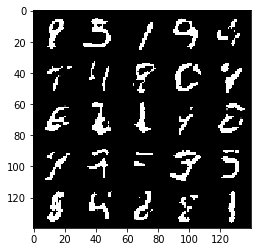

Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.9541 Sum Loss: 2.7831
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 1.8382 Sum Loss: 2.5768
Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 2.3911 Sum Loss: 3.3914
Epoch 1/2... Discriminator Loss: 1.9146... Generator Loss: 4.0660 Sum Loss: 5.9806
Epoch 1/2... Discriminator Loss: 1.0051... Generator Loss: 1.9355 Sum Loss: 2.9407
Epoch 1/2... Discriminator Loss: 1.7442... Generator Loss: 2.8371 Sum Loss: 4.5813
Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 1.4977 Sum Loss: 2.2515
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 0.8202 Sum Loss: 1.7244
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 2.6573 Sum Loss: 3.5273
Epoch 1/2... Discriminator Loss: 1.6445... Generator Loss: 0.3490 Sum Loss: 1.9935


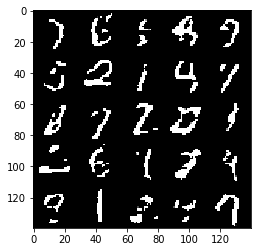

Epoch 1/2... Discriminator Loss: 0.5906... Generator Loss: 1.4845 Sum Loss: 2.0751
Epoch 1/2... Discriminator Loss: 0.4571... Generator Loss: 1.6797 Sum Loss: 2.1368
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.5831 Sum Loss: 1.9465
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 1.3224 Sum Loss: 2.3332
Epoch 1/2... Discriminator Loss: 1.6147... Generator Loss: 0.3834 Sum Loss: 1.9980
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 1.2987 Sum Loss: 2.0532
Epoch 1/2... Discriminator Loss: 0.3534... Generator Loss: 1.9915 Sum Loss: 2.3449
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 0.9368 Sum Loss: 1.7200
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 0.8990 Sum Loss: 1.7888
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 0.5434 Sum Loss: 2.0562


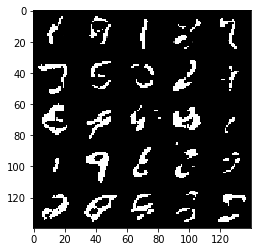

Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 0.4134 Sum Loss: 1.8884
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.6751 Sum Loss: 1.7291
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 1.5324 Sum Loss: 2.0711
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.4057 Sum Loss: 2.3526
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 0.7968 Sum Loss: 1.8243
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 1.1578 Sum Loss: 2.0954
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 0.8652 Sum Loss: 1.8022
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 1.0011 Sum Loss: 1.8298
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.0834 Sum Loss: 2.0034
Epoch 2/2... Discriminator Loss: 0.7632... Generator Loss: 1.1170 Sum Loss: 1.8801


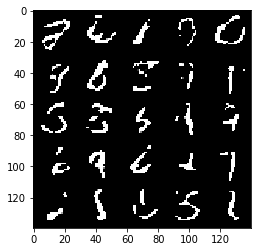

Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.6211 Sum Loss: 1.8362
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 3.4103 Sum Loss: 4.4523
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 2.5733 Sum Loss: 3.7897
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 0.9799 Sum Loss: 1.8026
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 1.8301 Sum Loss: 2.3813
Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 1.0536 Sum Loss: 1.8009
Epoch 2/2... Discriminator Loss: 0.5792... Generator Loss: 1.2107 Sum Loss: 1.7899
Epoch 2/2... Discriminator Loss: 0.4242... Generator Loss: 1.6850 Sum Loss: 2.1092
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 2.2615 Sum Loss: 3.0990
Epoch 2/2... Discriminator Loss: 0.4829... Generator Loss: 1.4879 Sum Loss: 1.9708


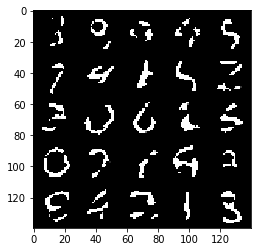

Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 0.9749 Sum Loss: 1.7065
Epoch 2/2... Discriminator Loss: 0.6090... Generator Loss: 1.4331 Sum Loss: 2.0420
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 1.0430 Sum Loss: 1.8305
Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 1.5937 Sum Loss: 2.0164
Epoch 2/2... Discriminator Loss: 3.1961... Generator Loss: 0.0962 Sum Loss: 3.2923
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 0.9654 Sum Loss: 1.9479
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 3.7647 Sum Loss: 5.1142
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.4458 Sum Loss: 2.1979
Epoch 2/2... Discriminator Loss: 0.7272... Generator Loss: 1.1554 Sum Loss: 1.8825
Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 0.7323 Sum Loss: 1.7680


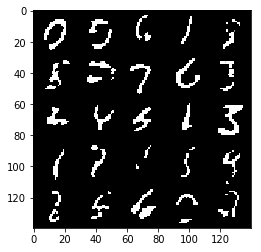

Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.6422 Sum Loss: 2.0618
Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 3.2518 Sum Loss: 3.6107
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.5399 Sum Loss: 1.7996
Epoch 2/2... Discriminator Loss: 0.8337... Generator Loss: 0.8338 Sum Loss: 1.6675
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 0.8571 Sum Loss: 1.6970
Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 2.2145 Sum Loss: 2.7550
Epoch 2/2... Discriminator Loss: 0.5814... Generator Loss: 1.1978 Sum Loss: 1.7792
Epoch 2/2... Discriminator Loss: 0.3947... Generator Loss: 1.8177 Sum Loss: 2.2124
Epoch 2/2... Discriminator Loss: 1.8416... Generator Loss: 0.5389 Sum Loss: 2.3805
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 1.2733 Sum Loss: 2.1230


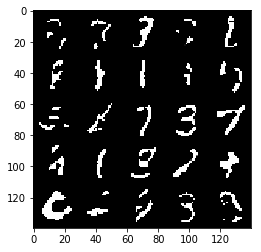

Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.3941 Sum Loss: 2.0570
Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.1130 Sum Loss: 1.8623
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 0.8039 Sum Loss: 1.8554
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.5250 Sum Loss: 1.8885
Epoch 2/2... Discriminator Loss: 0.5374... Generator Loss: 2.3551 Sum Loss: 2.8926
Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 2.4016 Sum Loss: 2.9028
Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 1.3259 Sum Loss: 1.9536
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.2507 Sum Loss: 1.8665
Epoch 2/2... Discriminator Loss: 1.5561... Generator Loss: 0.4494 Sum Loss: 2.0056
Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 2.0369 Sum Loss: 2.5674


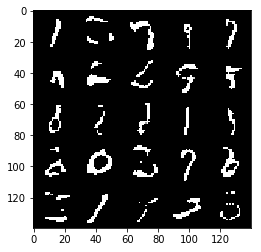

Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 1.5419 Sum Loss: 2.2172
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 2.1856 Sum Loss: 3.2549
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 0.8723 Sum Loss: 1.6806
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 1.2132 Sum Loss: 2.0518
Epoch 2/2... Discriminator Loss: 1.7663... Generator Loss: 0.4273 Sum Loss: 2.1935
Epoch 2/2... Discriminator Loss: 1.6851... Generator Loss: 0.3310 Sum Loss: 2.0161
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 3.0314 Sum Loss: 3.9302
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 0.7618 Sum Loss: 1.7787
Epoch 2/2... Discriminator Loss: 0.5857... Generator Loss: 1.4082 Sum Loss: 1.9939
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.4864 Sum Loss: 2.0070


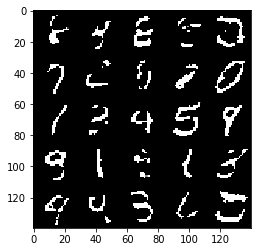

Epoch 2/2... Discriminator Loss: 0.5154... Generator Loss: 1.9752 Sum Loss: 2.4905
Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 2.0809 Sum Loss: 2.6877
Epoch 2/2... Discriminator Loss: 0.4775... Generator Loss: 1.4949 Sum Loss: 1.9723
Epoch 2/2... Discriminator Loss: 0.3309... Generator Loss: 1.9949 Sum Loss: 2.3258
Epoch 2/2... Discriminator Loss: 3.2398... Generator Loss: 0.0884 Sum Loss: 3.3282
Epoch 2/2... Discriminator Loss: 1.5153... Generator Loss: 0.5144 Sum Loss: 2.0298
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.7269 Sum Loss: 1.9599
Epoch 2/2... Discriminator Loss: 0.7850... Generator Loss: 2.3835 Sum Loss: 3.1685
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.3932 Sum Loss: 2.1585
Epoch 2/2... Discriminator Loss: 1.4024... Generator Loss: 0.6986 Sum Loss: 2.1010


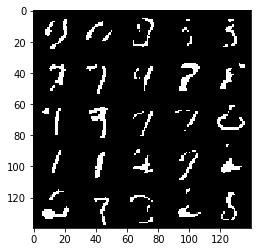

Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 0.7037 Sum Loss: 1.9057
Epoch 2/2... Discriminator Loss: 1.5439... Generator Loss: 0.4529 Sum Loss: 1.9967
Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 1.8563 Sum Loss: 2.3961
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.7007 Sum Loss: 1.8450
Epoch 2/2... Discriminator Loss: 0.5930... Generator Loss: 1.4439 Sum Loss: 2.0370
Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 1.1929 Sum Loss: 2.0457
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 2.5882 Sum Loss: 3.5754
Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 2.5475 Sum Loss: 2.9787
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 0.7659 Sum Loss: 1.7916
Epoch 2/2... Discriminator Loss: 0.7340... Generator Loss: 1.6335 Sum Loss: 2.3674


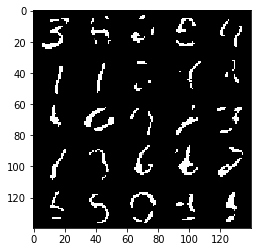

Epoch 2/2... Discriminator Loss: 0.5011... Generator Loss: 1.4957 Sum Loss: 1.9968
Epoch 2/2... Discriminator Loss: 1.5525... Generator Loss: 0.4316 Sum Loss: 1.9841
Epoch 2/2... Discriminator Loss: 0.4192... Generator Loss: 2.6295 Sum Loss: 3.0487
Epoch 2/2... Discriminator Loss: 1.7893... Generator Loss: 0.3486 Sum Loss: 2.1380
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.1827 Sum Loss: 1.8667
Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 2.5095 Sum Loss: 3.1051
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 3.7209 Sum Loss: 4.7366
Epoch 2/2... Discriminator Loss: 0.5713... Generator Loss: 2.7950 Sum Loss: 3.3663
Epoch 2/2... Discriminator Loss: 0.5852... Generator Loss: 1.2648 Sum Loss: 1.8500
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 0.8585 Sum Loss: 1.8423


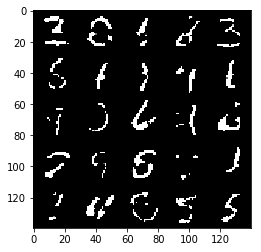

Epoch 2/2... Discriminator Loss: 0.7260... Generator Loss: 1.0157 Sum Loss: 1.7418
Epoch 2/2... Discriminator Loss: 0.2000... Generator Loss: 2.6583 Sum Loss: 2.8583
Epoch 2/2... Discriminator Loss: 0.3794... Generator Loss: 1.8251 Sum Loss: 2.2045
Epoch 2/2... Discriminator Loss: 0.2329... Generator Loss: 2.7806 Sum Loss: 3.0135
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 2.6346 Sum Loss: 3.0973
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 1.6258 Sum Loss: 2.1812
Epoch 2/2... Discriminator Loss: 2.2302... Generator Loss: 0.3420 Sum Loss: 2.5722


In [104]:
#minist
batch_size = 64
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 0.0202... Generator Loss: 22.4380 Sum Loss: 22.4582
Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 21.4461 Sum Loss: 21.5810
Epoch 1/1... Discriminator Loss: 0.3158... Generator Loss: 6.5973 Sum Loss: 6.9131
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 5.8002 Sum Loss: 5.8520
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 7.7996 Sum Loss: 8.0234
Epoch 1/1... Discriminator Loss: 2.6190... Generator Loss: 0.3498 Sum Loss: 2.9688
Epoch 1/1... Discriminator Loss: 6.7199... Generator Loss: 8.0563 Sum Loss: 14.7761
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.1840 Sum Loss: 2.0342
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.9025 Sum Loss: 2.0289
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.5107 Sum Loss: 1.7478


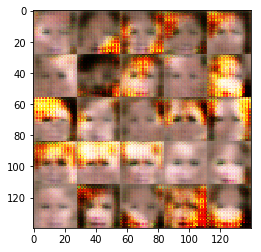

Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 2.1134 Sum Loss: 2.8668
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 1.5098 Sum Loss: 2.7721
Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 1.3144 Sum Loss: 1.8923
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.6470 Sum Loss: 2.2315
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.7432 Sum Loss: 1.8876
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 1.4594 Sum Loss: 2.9718
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7971 Sum Loss: 1.9759
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.5457 Sum Loss: 1.7794
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.2431 Sum Loss: 2.4720
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 1.2093 Sum Loss: 2.4541


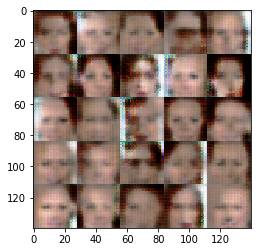

Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 1.0853 Sum Loss: 2.5219
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 1.2770 Sum Loss: 2.5950
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.5848 Sum Loss: 1.8471
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 0.8704 Sum Loss: 1.8181
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.9792 Sum Loss: 2.1500
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.8853 Sum Loss: 1.7662
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.6759 Sum Loss: 1.8257
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 0.7923 Sum Loss: 1.6120
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.0780 Sum Loss: 2.0308
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.7901 Sum Loss: 2.0472


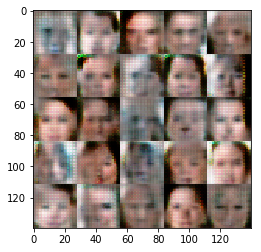

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7000 Sum Loss: 2.0113
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.7429 Sum Loss: 2.0097
Epoch 1/1... Discriminator Loss: 2.7702... Generator Loss: 0.1015 Sum Loss: 2.8716
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6861 Sum Loss: 2.0895
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 1.0541 Sum Loss: 2.4139
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.2704 Sum Loss: 2.0005
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.6197 Sum Loss: 1.7329
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.8709 Sum Loss: 1.9740
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 1.2409 Sum Loss: 2.5132
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.5274 Sum Loss: 1.7142


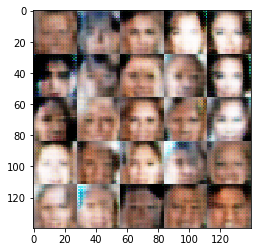

Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6088 Sum Loss: 1.9839
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 1.3987 Sum Loss: 2.7042
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.7888 Sum Loss: 2.0427
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.3990 Sum Loss: 1.7713
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7618 Sum Loss: 2.0344
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7548 Sum Loss: 2.1064
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7068 Sum Loss: 2.0887
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.6977 Sum Loss: 1.9451
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.5315 Sum Loss: 1.7752
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.4561 Sum Loss: 1.9687


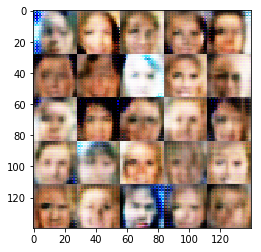

Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.9902 Sum Loss: 2.1147
Epoch 1/1... Discriminator Loss: 3.8978... Generator Loss: 3.4629 Sum Loss: 7.3607
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.6342 Sum Loss: 1.7732
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.4370 Sum Loss: 1.7692
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.0629 Sum Loss: 1.7767
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7660 Sum Loss: 2.2049
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8408 Sum Loss: 2.0425
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6199 Sum Loss: 1.9748
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.5691 Sum Loss: 1.8925
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7525 Sum Loss: 2.0208


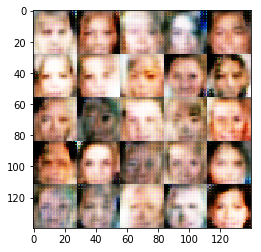

Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.5857 Sum Loss: 1.8151
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.1627 Sum Loss: 1.8937
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6131 Sum Loss: 1.8803
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5194 Sum Loss: 1.9939
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.8207 Sum Loss: 2.0152
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.6347 Sum Loss: 1.8959
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 1.1326 Sum Loss: 2.5221
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.2842 Sum Loss: 1.8711
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8361 Sum Loss: 2.2062
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.8412 Sum Loss: 2.5628


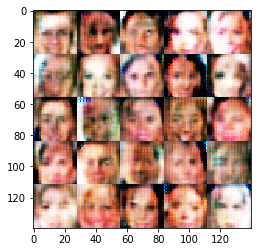

Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6021 Sum Loss: 1.9191
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.6207 Sum Loss: 1.7852
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.9719 Sum Loss: 2.0365
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.7919 Sum Loss: 1.9690
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8992 Sum Loss: 2.3353
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.9831 Sum Loss: 2.3368
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.5442 Sum Loss: 1.8058
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.6313 Sum Loss: 1.6304
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6342 Sum Loss: 2.1264
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 1.0828 Sum Loss: 2.4999


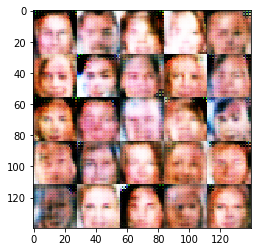

Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.9568 Sum Loss: 2.0847
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7464 Sum Loss: 1.9785
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.5827 Sum Loss: 2.0416
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6596 Sum Loss: 2.1050
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.8545 Sum Loss: 2.1080
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.9431 Sum Loss: 2.5341
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7394 Sum Loss: 2.0676
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.5868 Sum Loss: 1.8394
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.1384 Sum Loss: 1.8384
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.1767 Sum Loss: 2.2987


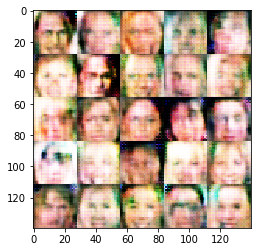

Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.8474 Sum Loss: 2.0823
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.5518 Sum Loss: 1.8037
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 0.9875 Sum Loss: 1.6771
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.4531 Sum Loss: 2.7109
Epoch 1/1... Discriminator Loss: 2.7280... Generator Loss: 2.3281 Sum Loss: 5.0561
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.4071 Sum Loss: 1.7774
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0665 Sum Loss: 2.1597
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.3304 Sum Loss: 1.7723
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8239 Sum Loss: 2.2362
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7794 Sum Loss: 2.0153


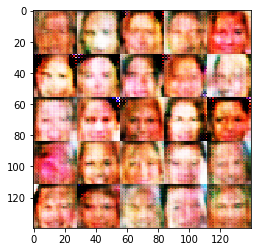

Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.8825 Sum Loss: 2.0217
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8176 Sum Loss: 2.1124
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7675 Sum Loss: 2.0797
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7829 Sum Loss: 2.0697
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7356 Sum Loss: 2.0334
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.8442 Sum Loss: 1.8947
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6164 Sum Loss: 2.0806
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7922 Sum Loss: 2.0948
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.6303 Sum Loss: 1.6284
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.6691 Sum Loss: 1.8245


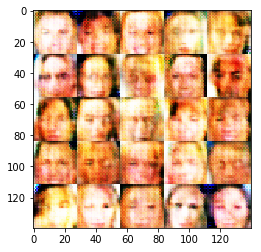

Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7704 Sum Loss: 1.9071
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.3604 Sum Loss: 1.7551


KeyboardInterrupt: 

In [102]:
#CelebA
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)